<a href="https://colab.research.google.com/github/Jamie3099/JamieGISWork/blob/master/3_street_grid_orientationsJamie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Orientation within street grid maps** ##

This practical class aims to help you to further expand your interpretative capabilities of the archaeological record within place and space. This week, we'll explore Urban Landscape and more specifically how past urbanisation can define the shape of modern cities. Through two contrasting examples, you’ll make use of open source data, and start thinking, qualifying and quantifying the diverse layout of modern cities. 

<font color='magenta'> ~ new ~</font> This practical lab will provide you ways to do so by:
   * using orientation to explore spatial patterns;
   * using classification of multiple variables to understand clusters in space;
   * **need to expand**

### Getting started #### 
<font color='orangered'> ~ déjà vu ~</font> Make your own copy of this notebook. 

<font color='magenta'> ~ new ~</font> Most basic tools we need are pre-installed in google ColabReseach. The tools for this exercise are not, so we need to do some extra setup. 


### Install `libspatialindex` -- run once per on startup

In [8]:
# Most basic tools we need are pre-installed in google colab. The tools for this exercise are not, so we need to do some extra setup. 
# Run this cell to install some necessary libraries. Then move on.
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz 2>/dev/null | tar xz
!apt-get install -qq g++ make
import os
os.chdir('/content/spatialindex-src-1.8.5')
!mount -o remount,exec /content
!./configure 2>&1 >/dev/null && make 2>&1 >/dev/null && make install && ldconfig
!pip install -q rtree

!pip install geopandas

!pip install osmnx

mount: /content: mount point not mounted or bad option.
./configure: line 6204: /usr/bin/file: No such file or directory
/content/spatialindex-src-1.8.5/missing: Unknown `--is-lightweight' option
Try `/content/spatialindex-src-1.8.5/missing --help' for more information
configure: WARNING: 'missing' script is too old or missing
Making install in src
make[1]: Entering directory '/content/spatialindex-src-1.8.5/src'
Making install in storagemanager
make[2]: Entering directory '/content/spatialindex-src-1.8.5/src/storagemanager'
make[3]: Entering directory '/content/spatialindex-src-1.8.5/src/storagemanager'
make[3]: Nothing to be done for 'install-exec-am'.
make[3]: Nothing to be done for 'install-data-am'.
make[3]: Leaving directory '/content/spatialindex-src-1.8.5/src/storagemanager'
make[2]: Leaving directory '/content/spatialindex-src-1.8.5/src/storagemanager'
Making install in spatialindex
make[2]: Entering directory '/content/spatialindex-src-1.8.5/src/spatialindex'
make[3]: Enterin

###Getting your tools

In [0]:
##codecell_StreetGridOrientations_ImportUrLibraries

# Now get the tools we need,as usual

from rtree import index
from rtree.index import Rtree
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# note that osmnx is the special tool here - it contains data on street networks and tools for analysing that data
import osmnx as ox
ox.config(log_console=True, use_cache=True)
weight_by_length = False

### Learning a new language – decomposing the code
in #codecell_StreetGridOrientations_ImportUrLibraries:

<font color='orangered'> ~ déjà vu ~</font> All libraries you have worked with so far are detailed in the Webmaps and Distributions notebook's lexicode.  

<font color='magenta'> ~ new ~</font> This week, you will still be working with some of these libraries, we are highligting two packages that deserve further attention:
* **rtree** is a spatial index library that allows you to import spatial analysis by number (a bit like ordering food by number!). Details can be viewed [here](http://toblerity.org/rtree/), this week we'll focus on **xxx**;
* **osmnx** is a valuable Python package, and it is open source. We should therefore  cite Geoff Boeing's work and [paper](https://geoffboeing.com/publications/osmnx-complex-street-networks/) *'OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks'*. The package allows you to download administrative boundary shapes and street networks (=geometries) from OpenStreetMap from which you can construct, project, visualise, and analyse complex street networks. Because OSMnx is built on top of NetworkX, matplotlib, and geopandas - that you have already used - the network analysis and spatial queries generation with R-tree is rich and fast. Further OsMnx documentation can be found [here](https://osmnx.readthedocs.io/en/stable/).

## **Assessing street grid orientations** ##

The origin and spread of cities can be studied as a function of their distribution, position, site, purpose and anatomy (Stanislawski D., 1946, [ref]( www.jstor.org/stable/211076)). In this practical lab, we will compare modern street grid orientations.
>>
<img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fgeoffboeing.com%2Fwp-content%2Fuploads%2F2017%2F04%2Fsquare-mile-street-networks-1024x822.jpg&f=1&nofb=1" width="400"/> </div> 
>
*Geoff Boeing - Urban Form Analysis with OpenStreetMap Data*
>>
We start by choosing two cities. I've chosen Rome and Milan. If you've been to these cities, recall how the streets are organized. Are they laid out in neat parallel lines? Are there dominant directions in which the streets run? 


In [0]:
##codecell_StreetGridOrientations_listing

# Here we are making a list using {} of all the places we want to study. We give a short name - or label - to each place name. 
# We use the format of 'label' : 'query' where the query is the full name of the place as written in our osmnx data source

places = {'Rome'       : 'Rome,Italy',
          'Milan'        : 'Milan,Italy'
          }

 **Listing** Now, we can do a basic check of the data contained in our list of places. 



In [11]:
##codecell_StreetGridOrientations_geodataframe

# create a geodataframe 'gdf' that lists the information from each of the places we've added to our list above
gdf = ox.gdf_from_places(places.values())
#type the name of the geodataframe to print it out
gdf

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"MULTIPOLYGON (((12.23447 41.74005, 12.23459 41...","Rome, Roma Capitale, Lazio, Italy",42.141028,41.655642,12.85576,12.234467
1,"POLYGON ((9.04089 45.44745, 9.04093 45.44727, ...","Milan, Lombardy, Italy",45.535848,45.386738,9.27811,9.040887


**Geodataframe** To analyse urban street orientations for one city, start by getting a polygon that describes the shape of a city. In this case, we're getting the data for Rome. We need to know the overall shape and spatial limits of the city to run this analysis.

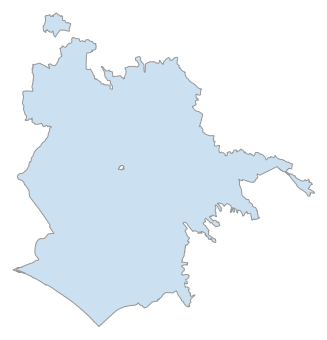

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f23ca653550>)

In [13]:
##codecell_StreetGridOrientations_shapeofgeodataframe

#Get the data for Rome
city = ox.gdf_from_place('Rome, Italy')
#Plot the shape data on the map
ox.plot_shape(ox.project_gdf(city))

#### **Learning a new language – decomposing the code**
As we are working with place and space, in *#codecell_StreetGridOrientations_geodataframe*, you have been creating a GeoDataFrame (using pandas) which is simply a dataFrame of Rome and Milan streets that has a column with geometry. The dataframe called under <font color='magenta'> ox gdf = ox.gdf_from_place()</font> provides you with their geographical extents are provided under *'bbox_north, bbox_south, bbox_east and bbox_west columns'*. A column *'geometry'* containing their geometries is populated. It describes them as polygons and multipolygons (& also contains their latitude and longitude in brackets). 
In *#codecell_StreetGridOrientations_shapeofgeodataframe* you have generated a plot of Rome containing multipolygon features which is often the case when places are split by landscape (e.g.rivers,etc), or different geo-political zones within the same city as it the case for Rome with the Vatican. 
>
 **why does it matter?**
Topology characterisation is important in geographical information systems (GIS) for:
* spatial functions (e.g. network routing via linear networks)
* better data quality and integrity control 
* creating topological relationships between features.
A coordinate-based data model that represents geographic features as points, lines and polygons (see image below) is called a vector model in GIS.
>
>
<img src="https://github.com/Francoz-Charlotte/Spatial_teaching_CFediting/blob/master/GISfeatures.png?raw=1" width="400"/> </div>
>


 **In which direction these features are running?**

 So we have x and y coordinates for our features, however the axes on which these features run is so far undefined. So, we need to consider how to check the **orientation** of a line (vector). Imagine a straight vertical line. Does it run up (toward 0 on a circle) or down (toward 180 on a circle)? 
 
 Of course, really it does both! To assess orientations, we rearrange the data between the streets which are running up and running down. We can therefore define that any street recorded as running down (values between 90 and 270 on a circle) will be reversed, and, so that they are analysed as if they run up. 
 



In [0]:
##codecell_StreetGridOrientations_RearrangeAxes

# reverse all downward running streets so they act as if they run up...
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

#### **Learning a new language – decomposing the code**

The ##codecell_StreetGridOrientations_RearrangeAxes is doing just that:
![orientations](https://github.com/Francoz-Charlotte/Spatial_teaching_CFediting/blob/master/Orientations_explain2b.png?raw=true)

<font color='orangered'> ~ déjà vu ~</font> Last week, in #codecell_Webmaps&Distributions_AllNumbers, you have seen that you could define a function using *def* argument, and in your first lab, #codecell_makeabasicmap_ManipulatingyourData_UsingSymbology,  you have used *if  elif  else* function.  Here, you are using both by calling (*def*) this new function (*reverse_bearing*) which is asking to add 180 degrees to all streets which are less than 180 and leave all streets which are not < 180 (*else* argument) as 180. 

**why does it matter?**
in order to quantify these street systems directions for both cities, we need to define/assess their **bearings** (= a measure of direction or angle of movement). Some rules: 
* bearings are always measured from the North;
* in a clockwise direction;
* with three digits. 

So, to know the bearing (direction) of a line (i.e.street for us) going from A to B, for instance, we need , first, to have the start of the line, point A, relative to North and the end of the line, point B, relative to the north as depicted below:

<img src="https://github.com/Francoz-Charlotte/Spatial_teaching_CFediting/blob/master/Bearings.png?raw=1" width="200"/> </div>

Then, we need to consider on what direction, from the north, we need to be in order to walk/cycle/drive/fly along this line AB:

<img src="https://github.com/Francoz-Charlotte/Spatial_teaching_CFediting/blob/master/Bearings_2.png?raw=1" width="200"/> </div>

So for the street AB, the bearing B from point A can be measured as follows:

<img src="https://github.com/Francoz-Charlotte/Spatial_teaching_CFediting/blob/master/Bearings__3.png?raw=1" width="200"/> </div>

And similarly, along the same street AB, you can walk/cycle/drive/fly from point B to A and its bearing can be calculated as follows:

<img src="https://github.com/Francoz-Charlotte/Spatial_teaching_CFediting/blob/master/Bearings_4.png?raw=1" width="200"/> </div>

Next we will get the **bearing**, or main orientation, of each line representing a street in Rome.




In [0]:
##codecell_StreetGridOrientations_GetBearings

#define an empty set to hold information on all the bearings of the streets
bearings = {}
#for each city
for place in sorted(places.keys()):
    
    # get the graph of all the streets
    query = places[place]
    G = ox.graph_from_place(query, network_type='drive')
    
    # calculate edge bearings of the lines representing streets
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

#### **Learning a new language – decomposing the code**

The ##codecell_StreetGridOrientations_GetBearings contains a loop function  to get the street networks and their edge bearings. There are further explanations about the loop *for*  [here](https://realpython.com/python-for-loop/) if you need further explanations as it an important coding concept to untangle!

The code is decomposed (partially as you must have the hang of it by now) for you to adapt it if you require to adapt it for the city, town or village of your choice: 

<img src="https://github.com/Francoz-Charlotte/Spatial_teaching_CFediting/blob/master/LAb3_orientations_GetBearings.png?raw=1" width="1600"/> </div>

<img src="https://github.com/Francoz-Charlotte/Spatial_teaching_CFediting/blob/master/LAb3_orientations_GetBearings2.png?raw=1" width="800"/> </div>

**Reminder** in a network, street network for us, you have principally 2 components, a **vertices** and **edges**. The vertices are the set of objects=nodes that are connected together and edges are all the connections between the nodes which are linking these vertices together. Here we simply want to quantidying the directions of these edges.


**To visualise these bearings** 
>
Step 1 - We count the number of streets with each orientation. 
*Note* that details and explanations about the code is explained within the codecell itself this time!

In [0]:
##codecell_StreetGridOrientations_SetBearings4visualisation

# here (and above and just below) you are still defining a function 
# part of your loop = little script that runs repeatedly on all your data
# here we go back to the *def* function, used in  #codecell_Webmaps&Distributions_AllNumbers 

def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)

    ## what's new here np.histogram function allows you to get a sense of the relative frequency (how many time an event is occuring) of the street's spatial orientations
    ##np.arrange = return evenly spaced values within a given interval
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

Step 2 - we will draw a diagram that shows the number of streets running along each orientation. We'll be using a type of diagram called a **'polar plot'** which is a an histogram (showing the frequency) in polar coordinates using the streets' set of bearings. Read about them [here](https://datavizproject.com/data-type/polar-area-chart/). 


In [0]:
##codecell_StreetGridOrientations_CreatingPolarPlot

# create a function to draw a polar histogram for a set of edge bearings
# here we create axes of the graph

def polar_plot(ax, bearings, n=36, title=''):
    
    #define bins to divide up the data
    #you want to make sure that your data is arranged 
    #following polar coordinates within a circle/chart 
    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    #getting all angles starting from the place
    # set north to 0 and work clockwise from there
    #ax.set_theta_location is scaling the output so that maximum radius rests on the edge of the axes circle
    #and in a polar graph projection, the input dimensions are theta
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    #Symbology
    # set up colours, labels, and fonts for the diagram
    #ax.bar() are all the bars (representing the frequency) positioned at x-axis
    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    #ax.set_ylim()allows you to linits of your plot (bounding boxes, font, axes labels, titles, etc.)
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'Arial', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'Arial', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'Arial', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


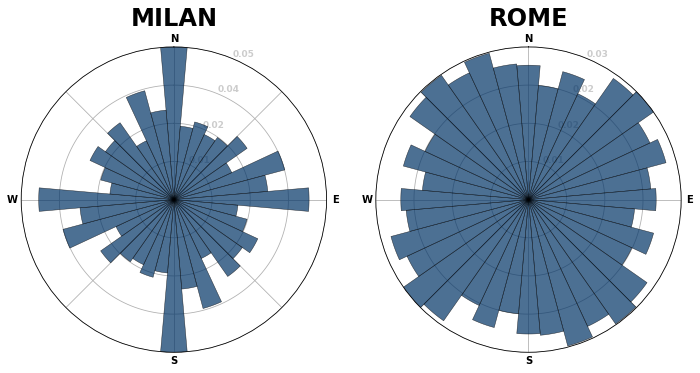

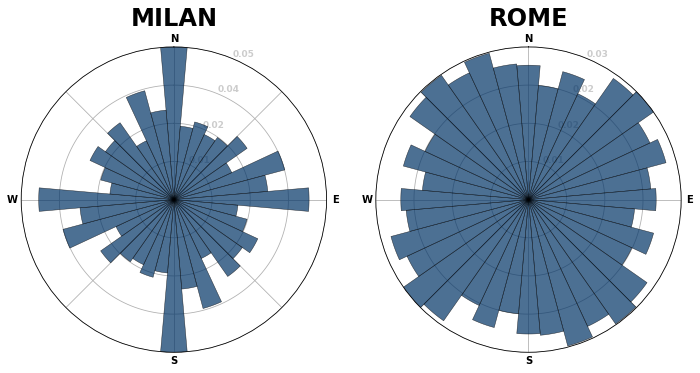

In [18]:
##codecell_StreetGridOrientations_VisualisePolarPlot

# visualise the figure and axes

# we are using *len* argument again (see #codecell_makeabasicmap_BringingUrData2theMap)
#plt.subplots() is creating just a figure with one subplot, easiest way to visualise graph before final output
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

# plot each city's polar histogram
# note here .dropna()allows you to drop/exclude field values NaN
# place your cursor over the brown field (i.e. zip or sorted) to find out what they mean
for ax, place in zip(axes.flat, sorted(places.keys())):
    polar_plot(ax, bearings[place].dropna(), title=place)

# add super title and save full image

fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
fig

##Orientations and frequency##

Are the orientations seen here similar or different? What might you conclude about the development and organization from each city based on these diagrams?

which other useful plots/diagram could also be used to quantify of street orientation ?
* rose diagrams — data that includes and implicit or explicit directional or temporal component can often be displayed most effectively using a plot that uses Cartesian coordinates rather than polar coordinates (polar). 
* Bubble plots — bubble plots are essentially scatterplots where the data items have an additional value or weighting (a third dimension) to be displayed. This is achieved by varying the size and/or color of the points. 




Now that you've started thinking about orientation and how we might interpret it, head to the next notebook (linked from the moodle) for a slightly more in depth exercise.

#LexiCode
To re-use the codes - you will need to first load their respective libraries.  So far, you have used ...:

<br>

> **libraries** |**plugins** |
>--- |--- | 
>folium | HeatMapWithTime
>branca| HeatMap
>pandas| MeasureControl
>geopandas| PrepareUrBasemaps_CreateLayers from [folium.plugins]
>seaborn | 
>matplotlib.pyplot | 
>numpy | 
>rtree | 
>osmnx |
>

your lexicode is non-exhaustive, keep expanding, find your own 'best way' to reuse these code/scripts...

<br>

>Lexicode_MakingaBasicMap | Lexicode_Webmaps&Distributions |Lexicode_StreetGridOrientations
>--- | --- | ---|
>	==   () [] | pd.concat() | { } *subselection from list*
>.head_csv() | .dtype() | ox.gdf_from_places()
>.read_csv() | astype() | ox.plot_shape()
>mean()  | fillna()|network_type= ''
>folium.Map | def return |ox.add_edge_bearings(ox.get_undirected())
>range() | .apply(lambda x:*function*,axis=) |count_and_merge()
>len() | pd.merge() |np.arrange()
>iloc[]| how= , left_index= ,left_index= |np.histogram()
>.value_counts()| gpd.GeoDataFrame()| ax.set_theta_location()
>if =:| geometry=gpd.points_from_xy |ax.set_ylim()
>elif =: |print() |ax.set_title()
>else =:| .isin()|ax.set_yticks()
>folium.Marker()| classic.plot()|ax.set_xlabels() & ax.set_yticklabels
>folium.Icon()| generateBaseMap()|plt.subplots()
>folium.Circle| .groupby(['', ''])|.dropna()
>popup= | .reset_index() |polar_plot()
>radius= |  max_zoom= |
>.values.tolist() |folium.TileLayer()
> .add_to()| plugins.DualMap(location= , tiles= , zoom_start= )
>  | 


